# Apache Spark MLib
### Why use Apache Spark for Machine Learning?
<strong>Scalability:</strong> Random forest, and and any other machine learning algorithm can be a computationally intensive algorithm that can be slow to run on large datasets, particularly on a single machine. However, Apache Spark allows us to distribute the computation across multiple nodes in a cluster, making it possible to train random forest models on much larger datasets and achieve faster performance.

<strong>Distributed Computing:</strong> With Spark, we can take advantage of distributed computing to parallelize the computation of machine learning models, making it faster and more efficient for large-scale datasets.

<strong>Integration with Other Spark Components:</strong> Apache Spark's ecosystem includes many components that can be used in conjunction with ML models to build end-to-end machine learning pipelines. For example, we can use Spark's DataFrames API to pre-process the data, Spark Streaming to train random forest models in real-time, and Spark's MLlib library to perform machine learning tasks.

<strong>Unified Analytics Engine:</strong> Apache Spark is a unified analytics engine that can be used for batch processing, stream processing, and interactive analytics. This makes it possible to use machine learning algorithms and analytical tools in the same platform, providing a more comprehensive analytics solution. <br><br>
Now, let's get familiarized with Apache Spark's Machine Learning library, MLib!

In [43]:
# install pyspark
! pip install pyspark seaborn

In [44]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(18, 5))

# create Spark Session
spark = SparkSession.builder.appName('DataFrameApp').master('local').getOrCreate()

<Figure size 1800x500 with 0 Axes>

## Regression
Dataset: [House Sales in King Country, USA](https://www.cs.ucy.ac.cy/courses/DSC511/data/kc_house_data_sm.csv) <br>
- House sale prices for King County including Seattle
- Contains an array of different housing attributes for homes sold between May 2014 and May 2015
- 22 features (id, # bedrooms, # bathrooms, sqf, floors, view, waterfront, day, month, year, etc.) + 1 target variable (label, i.e. price)
<br><br>
What shall we have? <strong>A regression problem, which is, to predict house prices.</strong><br>
Let's build and tune a Random Forest Model with Spark MLib using Python.

In [45]:
# TODO: Read the kc_house_data_sm dataset (with the header & infer the schema)
df = 

In [46]:
# TODO: Print schema
df.

root
 |-- id: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [47]:
# TODO: Print top 5 rows
df.

+----------+----+-----+---+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|year|month|day|   label|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----+-----+---+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|2014|   10| 13|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|2014|   12|  9|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|    1951

In [48]:
# TODO: Print top 5 rows for a selected columns (label, bedrooms, bathrooms, floors)
df.

+--------+--------+---------+------+
|   label|bedrooms|bathrooms|floors|
+--------+--------+---------+------+
|221900.0|       3|      1.0|   1.0|
|538000.0|       3|     2.25|   2.0|
|180000.0|       2|      1.0|   1.0|
|604000.0|       4|      3.0|   1.0|
|510000.0|       3|      2.0|   1.0|
+--------+--------+---------+------+
only showing top 5 rows



In [49]:
# TODO: Print some basic statistics for the columns lavel, bedrooms, bathrooms, floors, sqft_living and grade
df.

+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|            label|          bedrooms|         bathrooms|            floors|      sqft_living|             grade|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             5000|              5000|              5000|              5000|             5000|              5000|
|   mean|      539469.8546|            3.3714|           2.06215|            1.4326|        2061.0368|            7.5952|
| stddev|387311.4849515879|0.9103998053389034|0.7735919896258507|0.5107929344503277|923.7275087101343|1.1665372355070223|
|    min|          75000.0|                 0|               0.0|               1.0|              380|                 3|
|    max|        7060000.0|                 9|              6.75|               3.5|            10040|                13|
+-------+---------------

## VectorAssembler

In [50]:
# Spark ML’s Random Forest class requires that the features are formatted as a single vector.
# So the first stage of this workflow is the VectorAssembler.
# This takes a list of columns that will be included in the new ‘features’ column
feature_list = []
for col in df.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
# create new column called features using VectorAssembler
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
newDf = assembler.transform(df)
# truncate=False indicates avoid truncating column content
newDf.select('features').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                   |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|[7.12930052E9,2014.0,10.0,13.0,3.0,1.0,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0]     |
|[6.414100192E9,2014.0,12.0,9.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.721,-122.319,1690.0,7639.0]|
|[5.6315004E9,2015.0,2.0,25.0,2.0,1.0,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0]        |
|[2.487200875E9,2014.0,12.0,9.0,4.0,3.0,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0]   |
|[1.95

## <strong>Train & Predict using Random Forest</strong>
### What is the Random Forest algorithm?

Random forest is a popular machine learning algorithm that is used for both <strong>regression and classification tasks</strong>. Additionally, it can be used for a wide range of applications, including image recognition, text classification, and anomaly detection. Here are some reasons why someone might want to use random forest:

<strong>Robustness:</strong> Random forest is a robust algorithm that can handle a wide range of data types and distributions, including categorical, numerical, and ordinal data. It is also less prone to overfitting than other decision tree-based algorithms.

<strong>Scalability:</strong> Random forest is a scalable algorithm that can handle large datasets and high-dimensional feature spaces. It can be parallelized across multiple CPUs or nodes, making it suitable for distributed computing environments.

<strong>Feature Selection:</strong> It can be used to perform feature selection, which is the process of identifying the most important features in the dataset. This can help to reduce the dimensionality of the dataset and improve the performance of the model.

<strong>Accuracy:</strong> It is often more accurate than other decision tree-based algorithms, particularly for high-dimensional datasets. It can also handle missing data and outliers well.

In [51]:
# Split Train & Test set
(trainingData, testData) = newDf.randomSplit([0.8, 0.2])

In [52]:
# The only inputs for the Random Forest model are the label and features.
# Parameters are assigned in the tuning piece.
rf = RandomForestRegressor(labelCol='label', featuresCol='features')

# Train the model
rf_model = rf.fit(trainingData)

# Make predictions
rf_predictions = rf_model.transform(testData)

# Select example rows to display
rf_predictions.select('prediction', 'label').show(10)

# Select (prediction, true label) and compute test error
rf_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print('Root Mean Squared Error (RMSE), using Random Forest, on test data = %d' % rf_rmse)

+------------------+---------+
|        prediction|    label|
+------------------+---------+
| 327734.1249937054| 178000.0|
| 792552.2151705354| 837700.0|
|  810768.240756303| 835000.0|
| 747360.3567174281| 810000.0|
| 458366.7684704947| 590000.0|
|404834.68446626625| 480000.0|
|305516.48322945915| 225000.0|
|1209626.3857988673|1060000.0|
| 871518.8877461456| 720000.0|
|  268702.800159057| 237500.0|
+------------------+---------+
only showing top 10 rows

Root Mean Squared Error (RMSE), using Random Forest, on test data = 173061


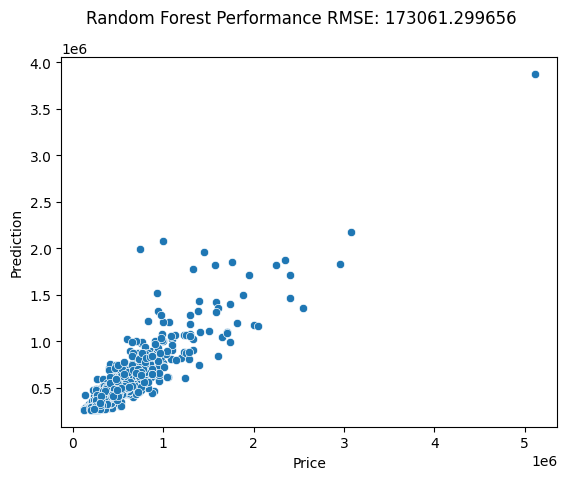

In [53]:
# Now, let's plot the RMSE
rfResult = rf_predictions.toPandas()
sns.scatterplot(x=rfResult.label, y=rfResult.prediction)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Random Forest Performance RMSE: %f" % rf_rmse)
plt.show()

## <strong>Train & Predict using Decision Tree</strong>
### What is the Decision Tree algorithm?
<strong>Decision tree</strong> is a popular machine learning algorithm that is also used for <strong>classification and regression tasks</strong>. In a decision tree, the data is split recursively into smaller subsets based on the values of different features until each subset contains data points that belong to the same class or have similar regression values.

In [54]:
# TODO: Create a Decision Tree model
dt = 

# TODO: Train the model
dt_model = dt.

# TODO: Make predictions
dt_predictions = dt_model.

# TODO: Select example rows to display (prediction and label)
dt_predictions.

# TODO: Compute test error as we have in the previous example
dt_evaluator = 
dt_rmse = dt_evaluator.
print('Root Mean Squared Error (RMSE), using Decision Tree, on test data = %d' % dt_rmse)

+------------------+---------+
|        prediction|    label|
+------------------+---------+
|         357456.75| 178000.0|
| 850763.6391752578| 837700.0|
| 741859.5224489796| 835000.0|
| 741859.5224489796| 810000.0|
|         508212.55| 590000.0|
|         357456.75| 480000.0|
|302293.39782016346| 225000.0|
|1312468.6176470588|1060000.0|
| 850763.6391752578| 720000.0|
| 239782.4288389513| 237500.0|
+------------------+---------+
only showing top 10 rows

Root Mean Squared Error (RMSE), using Decision Tree, on test data = 224440


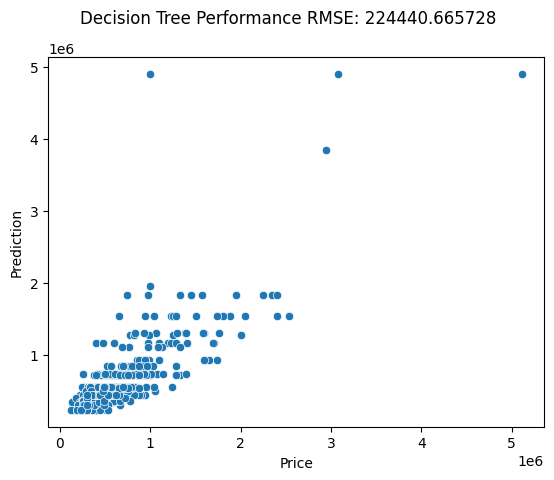

In [55]:
# TODO: Now, let's plot as before, using the Decision Tree RMSE
dtResult = dt_predictions.

## <strong>Train & Predict using Gradient-Boosted Tree</strong>
### What is the Gradient-Boosted Tree Algorithm?
<strong>Gradient boosted trees</strong> are also utilized for <strong>regression and classification tasks</strong>. In gradient boosted trees, a series of decision trees are trained sequentially, with each tree aiming to correct the errors made by the previous tree. The final prediction is a weighted combination of all the decision trees, with the weights determined by the performance of each tree. One of the advantages of this algorithm is its accuracy. Gradient boosted trees <strong>can yield highly accurate predictions</strong>, especially when applied to complex datasets with numerous features.

In [ ]:
# TODO: Create a Gradient-Boosted Trees model
gbt = 

# TODO: Train the model
gbt_model = gbt.

# TODO: Make predictions
gbt_predictions = gbt_model.

# TODO: Select prediction and label
gbt_predictions.

# TODO compute test error
gbt_evaluator = 
gbt_rmse = gbt_evaluator.
print('Root Mean Squared Error (RMSE), using Gradient Boosted Tree, on test data = %d' % gbt_rmse)

+------------------+--------+
|        prediction|   label|
+------------------+--------+
| 233028.3433219053|281000.0|
| 816336.1449713801|837700.0|
|222524.74650932613|189000.0|
|293601.41761538363|218500.0|
|203135.49128444912|130000.0|
| 224093.3152902572|190000.0|
|301293.27239991067|225000.0|
|227410.57682688264|170000.0|
| 311794.8779232542|359950.0|
| 837579.0316615555|785500.0|
+------------------+--------+
only showing top 10 rows

Root Mean Squared Error (RMSE), using Gradient Boosted Tree, on test data = 209540


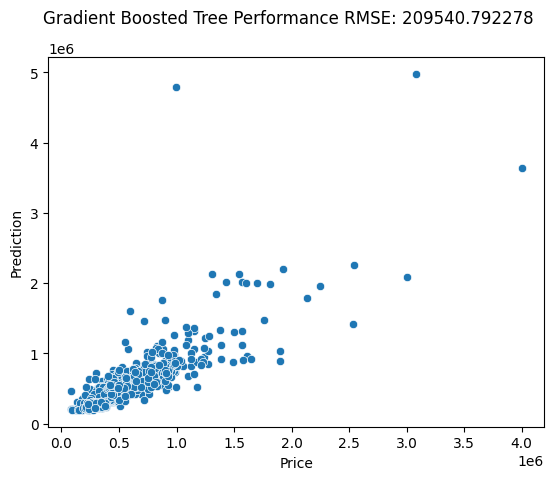

In [ ]:
# TODO: Plot Gradient Boosted Tree's RMSE
gbtResult = gbt_predictions.

## <strong>Random Forest Regression: CrossValidation with Pipeline && Parameter Grid</strong>

<strong>Cross-validation</strong> is a common technique used in machine learning to <strong>evaluate the performance of a model and select the best set of hyperparameters</strong>. It involves <em>dividing the data into several partitions</em>, where one partition is used for testing the model and the remaining partitions are used for training the model. <em>This process is repeated for each partition, and the results are averaged to get an estimate of the model's performance.</em>

In Apache Spark, cross-validation can be performed using the CrossValidator class, which is part of the pyspark.ml.tuning module.

In [58]:
# Now, we put our simple, two-stage workflow into an ML pipeline.
# Configure an ML pipeline, which consists of two stages: assembler, and rf (random forest).
pipeline = Pipeline(stages=[assembler, rf])

In [59]:
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for rf.numTrees and 3 values for rf.maxDepth, this grid will have 3 x 3 = 9 settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [60]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse"), numFolds=3)

In [61]:
# WARNING: This task can take a lot of time to be completed, execute this ONLY if you want to see it execute live.
(trainingData_cross, testData_cross) = df.randomSplit([0.8, 0.2], 0)
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainingData_cross)
# Make predictions on test documents. cvModel uses the best model found (rf).
predictions = cvModel.transform(testData_cross)

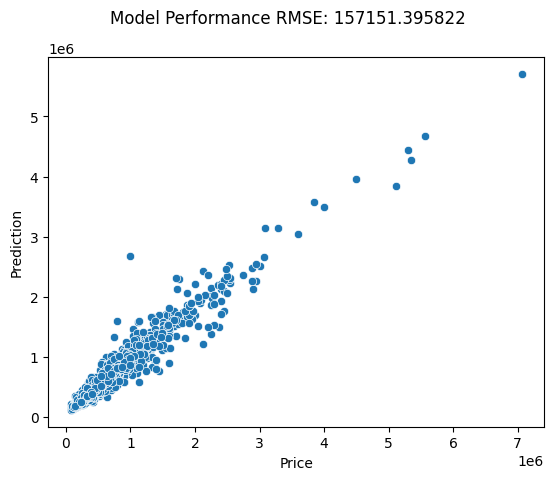

In [62]:
# Here, we will generate a scatter plot that allows us to visually inspect the performance of our regression model
# by comparing the predicted values to the true values.
# The RMSE value is also displayed in the plot title to provide a quantitative measure of model performance.
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction",
                                metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()
sns.scatterplot(x=rfResult.label, y=rfResult.prediction)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

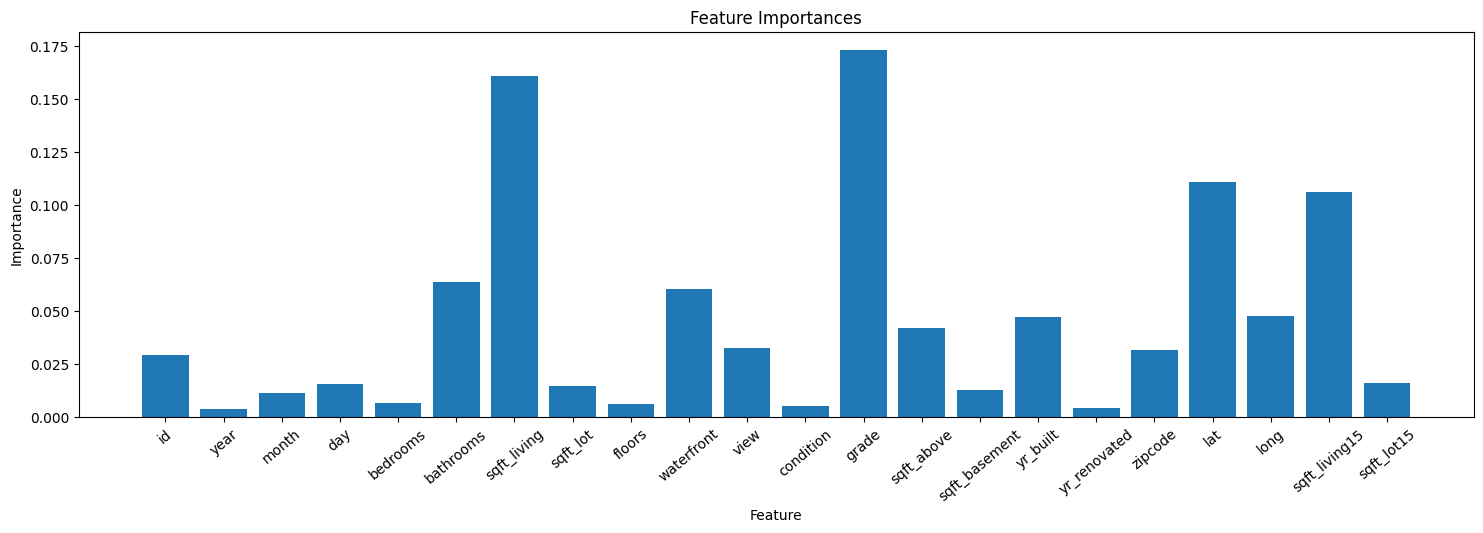

In [ ]:
plt.figure(figsize=(18, 5))

# let's create now a bar chart showing the importance of features in our machine learning model.
# Take the best model that our cross-validation (cvModel) selected
bestPipeline = cvModel.bestModel
# Then, we extract the best model from the pipeline (bestPipeline) and get the feature importances from the model (importances).
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## Clustering
Dataset: [Fleet Dataset](https://www.cs.ucy.ac.cy/courses/DSC511/data/fleet_data.csv) <br>
<ol><li>Includes 4000 drivers</li>
<li>Each observation has 3 columns: <br>
- Driver_ID<br>
- Distance_Feature: mean distance driven per day<br>
- Speeding_Feature: mean percentage of time a driver was >5 mph over the speed limit</li>
<li>No notion of groups (labels)</li></ol>

<strong> Clustering problem: find groups which have not been explicitly labeled in data to:</strong><br>
1. Confirm business assumptions about what types of groups exist or <br>
2. Identify unknown groups in complex data sets
<br>

We will build and tune a K-Means model with Spark MLib


In [64]:
# TODO: read and explore the dataset a bit (header and inferschema should be enabled)
df = 

# TODO: print schema
df.

# TODO: show a few lines of the dataset
df.

# TODO: select to get a few statistics on the columns Distance_Feature and Speeding_Feature
df.

root
 |-- Driver_ID: long (nullable = true)
 |-- Distance_Feature: double (nullable = true)
 |-- Speeding_Feature: double (nullable = true)

+----------+----------------+----------------+
| Driver_ID|Distance_Feature|Speeding_Feature|
+----------+----------------+----------------+
|3423311935|           71.24|            28.0|
|3423313212|           52.53|            25.0|
|3423313724|           64.54|            27.0|
|3423311373|           55.69|            22.0|
|3423310999|           54.58|            25.0|
|3423313857|           41.91|            10.0|
|3423312432|           58.64|            20.0|
|3423311434|           52.02|             8.0|
|3423311328|           31.25|            34.0|
|3423312488|           44.31|            19.0|
|3423311254|           49.35|            40.0|
|3423312943|           58.07|            45.0|
|3423312536|           44.22|            22.0|
|3423311542|           55.73|            19.0|
|3423312176|           46.63|            43.0|
|3423314176| 

In [65]:
# TODO: Now, using a VectorAssembler, we need to extract our features.
# For input, give an array with our dataset's columns, and the output should be the column "features"
assembler = 

# TODO: Transform your dataframe using the assembler, and select the features column
assembled = assembler.

assembled.show()

+------------+
|    features|
+------------+
|[71.24,28.0]|
|[52.53,25.0]|
|[64.54,27.0]|
|[55.69,22.0]|
|[54.58,25.0]|
|[41.91,10.0]|
|[58.64,20.0]|
| [52.02,8.0]|
|[31.25,34.0]|
|[44.31,19.0]|
|[49.35,40.0]|
|[58.07,45.0]|
|[44.22,22.0]|
|[55.73,19.0]|
|[46.63,43.0]|
|[52.97,32.0]|
|[46.25,35.0]|
|[51.55,27.0]|
|[57.05,26.0]|
|[58.45,30.0]|
+------------+
only showing top 20 rows



In [66]:
# Now, let's build the KNN model
K=2
kmeans = KMeans(k=K, initMode='k-means||', initSteps=2, tol=0.0001)

# TODO: Train the model (cluster the data)
model = kmeans.

# TODO: Make predictions
predictions = model.

# And, we will print the centers of the 4 clusters after training
centers = model.clusterCenters()
for center in centers:
    print(center)

[50.04763437  8.82875   ]
[180.017075  18.29    ]


<Axes: xlabel='Distance_Feature', ylabel='Speeding_Feature'>

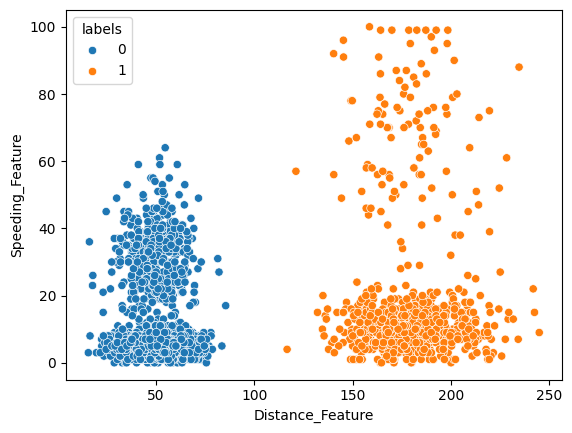

In [67]:
# Convert the input features and predictions to a Pandas DataFrame
data = df.select('Distance_Feature', 'Speeding_Feature').toPandas()
data['labels'] = list(predictions.select("prediction").toPandas()['prediction'])

# Create a scatter plot of the input features and predictions
sns.scatterplot(data=data, x="Distance_Feature", y="Speeding_Feature", hue="labels")

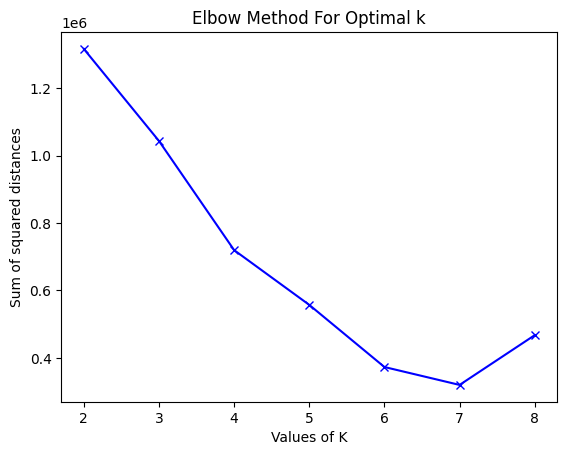

In [68]:
# Define a function to implement the elbow method
# (Using a graphical method to find the optimal K value in our k-means clustering algorithm)
def elbow_method(x):
    # Initialize an empty list to store the sum of squared distances
    Sum_of_squared_distances = []

    # Define a list of potential values of k
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

    # Loop through the potential values of k
    for num_clusters in range_n_clusters:
        # Initialize a KMeans object with the current value of k
        kmeans = KMeans(k=num_clusters, initMode='k-means||', initSteps=2, tol=0.0001)

        # Fit the KMeans model to the data
        model = kmeans.fit(x)

        # Append the sum of squared distances to the list
        Sum_of_squared_distances.append(model.summary.trainingCost)

    # Create a line plot of the sum of squared distances vs. the number of clusters
    plt.plot(range_n_clusters,Sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Call the elbow_method function on the assembled dataset
elbow_method(assembled)

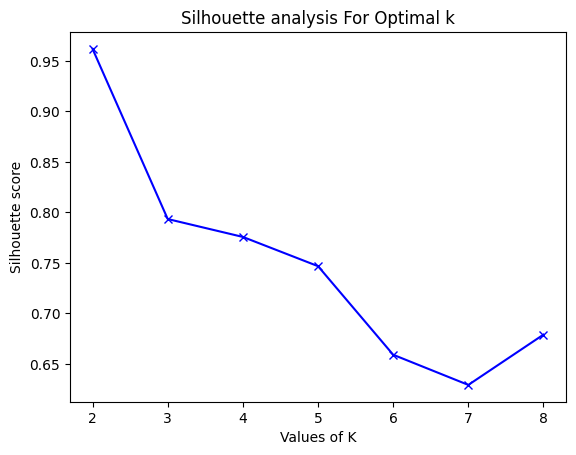

In [69]:
# The silhouette method, is to measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation)
def silhouette(x):
    # Define the range of K values to test
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

    # Create an empty list to store silhouette scores for each K value
    silhouette_avg = []

    # Loop through each K value and perform KMeans clustering
    for num_clusters in range_n_clusters:
        # Initialise KMeans with the current K value
        kmeans = KMeans(k=num_clusters, initMode='k-means||', initSteps=2, tol=0.0001)
        # Fit the KMeans model to the input dataset
        model = kmeans.fit(x)
        # Make predictions on the input dataset
        predictions = model.transform(x)

        # Compute Silhouette score to evaluate the clustering
        evaluator = ClusteringEvaluator()
        silhouette_avg.append(evaluator.evaluate(predictions))

    # Plot the silhouette scores for each K value
    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

# run silhouette method to create the figure shown below
silhouette(assembled)